In [22]:
import math
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap

RATES = [1,2,3,4,5]

def loadData(nbChunks = 0):  # <= 0 to load all chunks, positive integer to load specific number of chunks
    asinToIndex = {}
    scoreMatrix = []
    booksAsin = []
    index = 0
    chunks = pd.read_json(
        '../Dataset/Books.json', lines=True, chunksize=500000,
        typ="frame", orient="records", dtype={"asin": str, "overall": int, "unixReviewTime": int}
    )
    for chunk in chunks:
        for _, item in chunk.iterrows():
            asin = item["asin"]
            rate = item["overall"]
            if (asin not in asinToIndex):
                scoreMatrix.append([0,0,0,0,0])
                booksAsin.append(asin)
                asinToIndex[asin] = index
                index += 1
            row = asinToIndex[asin]
            scoreMatrix[row][rate-1] += 1
        nbChunks -= 1
        if (nbChunks == 0): break
    scoreMatrix = np.array(scoreMatrix)
    nbNonAppreciate = scoreMatrix[:,0]+scoreMatrix[:,1]
    nbNeutral = scoreMatrix[:,2]
    nbAppreciate = scoreMatrix[:,3]+scoreMatrix[:,4]
    realClass = np.argmax(np.column_stack((nbNonAppreciate, nbNeutral, nbAppreciate)), axis=1).astype(int)
    maxStarVotes = np.argmax(scoreMatrix, axis=1).astype(int)
    categoryMatrix = np.column_stack((nbNonAppreciate, nbNeutral, nbAppreciate, maxStarVotes, realClass))
    colNames = [f"{i} ⭐" for i in RATES]
    colNames.extend(["Depreciation", "Neutral", "Appreciations", "MaxStarVotes", "Class"])
    pdBooks = pd.DataFrame(data=np.concatenate((scoreMatrix, categoryMatrix), axis=1), index=booksAsin, columns=colNames)
    return pdBooks, scoreMatrix, categoryMatrix, booksAsin, asinToIndex

pdBooks, scoreMatrix, categoryMatrix, booksAsin, asinToIndex = loadData()
display(pdBooks)

def displayDifferentClassesCount(pdBooks):
    print("Different classes count : ")
    classesCount = np.array([
        [(pdBooks.Class.values == i).sum(), int(np.round(((pdBooks.Class.values == i).sum()/len(pdBooks.index))*100))] for i in range(0, 3)
    ])
    display(pd.DataFrame(
        data=np.array(classesCount),
        index=[ (i+1) * "⭐" for i in range(0,3) ],
        columns=["Count", "%"]
    ))

displayDifferentClassesCount(pdBooks)

,1 ⭐,2 ⭐,3 ⭐,4 ⭐,5 ⭐,Depreciation,Neutral,Appreciations,MaxStarVotes,Class
000100039X,6,4,8,15,173,10,8,188,4,2
0001055178,0,4,2,10,2,4,2,12,3,2
0001473123,1,0,0,2,13,1,0,15,4,2
0001473727,0,0,0,0,7,0,0,7,4,2
0001473905,0,0,1,0,5,0,1,5,4,2
...,...,...,...,...,...,...,...,...,...,...
B00LZFHL7Y,0,0,1,2,13,0,1,15,4,2
B00LZKMXBI,0,1,4,14,141,1,4,155,4,2
B00M029T4O,0,0,0,1,12,0,0,13,4,2
B00M0RE7CS,0,0,0,1,29,0,0,30,4,2


Different classes count : 


,Count,%
⭐,10243,3
⭐⭐,6398,2
⭐⭐⭐,351341,95


In [23]:
BOOKS_SAMPLING_NB = 3500
BAYES_QUARTILE_OPT = 0.25
colorsList = ["red", "orange", "green"]
colors = ListedColormap(colorsList)
CRITERIAS = ["Nb rating", "Average Rating", "Bayes Rating", "Median", "STD", "Depreciation", "Neutral", "Appreciations", "MaxStarVotes"]

class PlotData:
  def __init__(self, inputData, dataXY, dataLabels, title, axisLabels=[]):
    self.inputData = inputData
    self.dataXY = dataXY
    self.dataLabels = dataLabels
    self.title = title
    self.axisLabels = axisLabels

def getMedian(scoreMatrix, nbRating):
    def rowMedian(i):
        s = 0
        for k in sorted([0,1,2,3,4]):
            s += scoreMatrix[i,k]
            if s > nbRating[i] / 2:
                break
        return k + 1
    medianMat = np.array([ rowMedian(i) for i in range(0, nbRating.size) ])
    return medianMat

def getBookStats(pdBooks):
    scoreMatrix = pdBooks.to_numpy()
    starsMatrix = scoreMatrix[:,0:5]
    nbRating = np.sum(starsMatrix, axis=1)
    avgRatings = (np.average(starsMatrix, axis=1, weights=RATES) * np.sum(RATES)) / nbRating
    medianMat = getMedian(starsMatrix, nbRating)
    stdRatings = np.std(starsMatrix, axis=1)
    confidenceNumber = np.quantile(nbRating, BAYES_QUARTILE_OPT)
    arithAverage = np.mean(avgRatings)
    bayesAvgRatings = (nbRating * avgRatings + arithAverage * confidenceNumber) / (nbRating + confidenceNumber)
    calculatedPropsMat = np.column_stack((nbRating, avgRatings, bayesAvgRatings, medianMat, stdRatings))
    return pd.DataFrame(
        data=np.concatenate((calculatedPropsMat, scoreMatrix[:,5:]),axis=1),
        index=pdBooks.index, 
        columns=["Nb rating", "Average Rating", "Bayes Rating", "Median", "STD", "Depreciation", "Neutral", "Appreciations", "MaxStarVotes", "Class"]
    )

pdBooksFeatures = getBookStats(pdBooks.sample(BOOKS_SAMPLING_NB))
display(pdBooksFeatures)
displayDifferentClassesCount(pdBooksFeatures)

,Nb rating,Average Rating,Bayes Rating,Median,STD,Depreciation,Neutral,Appreciations,MaxStarVotes,Class
1484070291,131.0,4.793893,4.766608,5.0,43.558696,1.0,7.0,123.0,4.0,2.0
B006PW0OU8,12.0,3.416667,3.725887,4.0,2.332381,3.0,1.0,8.0,3.0,2.0
0142421014,10.0,4.400000,4.340698,5.0,2.190890,0.0,2.0,8.0,4.0,2.0
0743298853,191.0,4.209424,4.211070,5.0,36.657332,19.0,14.0,158.0,4.0,2.0
0452287146,82.0,3.304878,3.379684,3.0,7.812810,19.0,25.0,38.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...
B00KYRTNZ2,7.0,4.857143,4.556561,5.0,2.332381,0.0,0.0,7.0,4.0,2.0
1496021819,64.0,4.437500,4.419604,5.0,16.017490,5.0,3.0,56.0,4.0,2.0
0375833234,8.0,4.750000,4.519457,5.0,2.332381,0.0,0.0,8.0,4.0,2.0
B001GQ2BBS,5.0,4.000000,4.149322,4.0,1.095445,0.0,1.0,4.0,3.0,2.0


Different classes count : 


,Count,%
⭐,96,3
⭐⭐,67,2
⭐⭐⭐,3337,95


In [24]:
from nltk import cluster
from nltk.cluster import cosine_distance, euclidean_distance

NB_CLUSTERS = 3
CLASSES = [f"C{i+1}" for i in range(0, NB_CLUSTERS)]

def kmeansClustering(booksData, distFunc, show=False):
    # Standardize data before doing kmeans :
    data = ((booksData - booksData.mean()) / booksData.std()).to_numpy()
    if (distFunc == "cosine"):
        # Find initial centroids using K-means++ (KMeans of SKlearn)
        initialCenters = KMeans(n_clusters=NB_CLUSTERS, random_state=0, max_iter=1).fit(data).cluster_centers_.tolist()
        # Run clustering using cosine similarity : cos sim = 1 - cos dist
        kmeans = cluster.KMeansClusterer(num_means=NB_CLUSTERS, initial_means=initialCenters, distance=lambda x, y: 1 - cosine_distance(x, y))
        kmeansLabel = np.array(kmeans.cluster(data, assign_clusters=True))
    else:
        kmeans = KMeans(n_clusters=NB_CLUSTERS, random_state=0, max_iter=1000).fit(data)
        kmeansLabel = kmeans.labels_
    
    # K means
    if (show):
        print(f"K-means ({distFunc}):")
        display(pd.DataFrame(
            data=np.array([ [f"C{i+1}" for i in kmeansLabel] ]),
            index=["Class"],
            columns=booksData.index
        ))
        display(pd.DataFrame(
            data=np.array([[np.count_nonzero(kmeansLabel == i) for i in range(0, NB_CLUSTERS)]]),
            index=["Number of Classes"],
            columns=CLASSES
        ))
    return data, kmeansLabel

kmeansEucliCoords, kmeansEucliLabels = kmeansClustering(pdBooksFeatures[CRITERIAS], "euclidean", True)
kmeansCosCoords, kmeansCosLabels = kmeansClustering(pdBooksFeatures[CRITERIAS], "cosine", True)

K-means (euclidean):


,1484070291,B006PW0OU8,0142421014,0743298853,0452287146,B00BFUODK2,155972112X,B00HIBXKQK,1934284033,1493767550,...,1416578455,B00C8S9XU0,0345476832,B00JRID620,1931543585,B00KYRTNZ2,1496021819,0375833234,B001GQ2BBS,0871951762
Class,C2,C1,C2,C2,C1,C2,C1,C2,C1,C2,...,C1,C1,C2,C1,C1,C2,C2,C2,C1,C1


,C1,C2,C3
Number of Classes,1128,2360,12


K-means (cosine):


,1484070291,B006PW0OU8,0142421014,0743298853,0452287146,B00BFUODK2,155972112X,B00HIBXKQK,1934284033,1493767550,...,1416578455,B00C8S9XU0,0345476832,B00JRID620,1931543585,B00KYRTNZ2,1496021819,0375833234,B001GQ2BBS,0871951762
Class,C3,C2,C1,C3,C2,C1,C2,C3,C2,C1,...,C2,C2,C3,C2,C2,C1,C3,C1,C2,C2


,C1,C2,C3
Number of Classes,1975,1227,298


Standardized/Normalized books features matrix : 


,Nb rating,Average Rating,Bayes Rating,Median,STD,Depreciation,Neutral,Appreciations,MaxStarVotes,Class
1484070291,1.931169,1.041503,1.638446,0.658382,3.526553,-0.166945,0.560806,2.360946,0.475177,0.210642
B006PW0OU8,-0.237140,-1.625071,-1.680730,-0.880921,-0.271227,0.138096,-0.238605,-0.278371,-0.784762,0.210642
0142421014,-0.273582,0.278850,0.280088,0.658382,-0.284261,-0.319465,-0.105370,-0.278371,0.475177,0.210642
0743298853,3.024434,-0.090141,-0.133334,0.658382,2.890797,2.578425,1.493452,3.164217,0.475177,0.210642
0452287146,1.038336,-1.841515,-2.784879,-2.420224,0.233632,2.578425,2.959039,0.410147,-0.784762,0.210642
...,...,...,...,...,...,...,...,...,...,...
B00KYRTNZ2,-0.328245,1.163966,0.968544,0.658382,-0.271227,-0.319465,-0.371840,-0.301322,0.475177,0.210642
1496021819,0.710357,0.351457,0.531744,0.658382,0.989449,0.443137,0.027865,0.823257,0.475177,0.210642
0375833234,-0.310024,0.956517,0.850208,0.658382,-0.271227,-0.319465,-0.371840,-0.278371,0.475177,0.210642
B001GQ2BBS,-0.364687,-0.495626,-0.330268,-0.880921,-0.385173,-0.319465,-0.238605,-0.370173,-0.784762,0.210642


PC axis composition : 


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Nb rating,0.451104,0.161796,-0.071419,-0.091640,-0.036923,-0.000534,0.013868,0.024682,-0.391723,-7.753815e-01
Average Rating,-0.154940,0.441004,-0.284984,0.177251,0.393741,0.189584,-0.142124,-0.672845,-0.070582,2.220446e-16
Bayes Rating,-0.162190,0.430617,-0.410911,0.037792,0.278941,0.158121,-0.042800,0.712646,0.074039,-2.376571e-16
Median,-0.136320,0.439919,-0.002978,0.289585,-0.262581,-0.721927,0.336069,-0.030076,-0.006748,1.177444e-16
STD,0.402684,0.205337,-0.271851,-0.346322,-0.249834,-0.092062,-0.200781,-0.136042,0.687116,0.000000e+00
Depreciation,0.417672,-0.008703,0.248926,0.600458,0.209059,-0.179616,-0.543753,0.129308,0.077615,9.263204e-02
Neutral,0.437192,0.072792,0.187640,0.181775,0.313774,0.248722,0.710823,-0.006360,0.241749,1.060402e-01
Appreciations,0.430036,0.192563,-0.159736,-0.237093,-0.132014,-0.016489,-0.023154,0.012726,-0.546721,6.155959e-01
MaxStarVotes,-0.087016,0.425285,0.359272,0.210169,-0.586502,0.536971,-0.072253,0.023829,0.014276,-2.428613e-17
Class,-0.085831,0.367277,0.647425,-0.510864,0.361744,-0.163299,-0.133522,0.043636,0.018479,-1.734723e-17


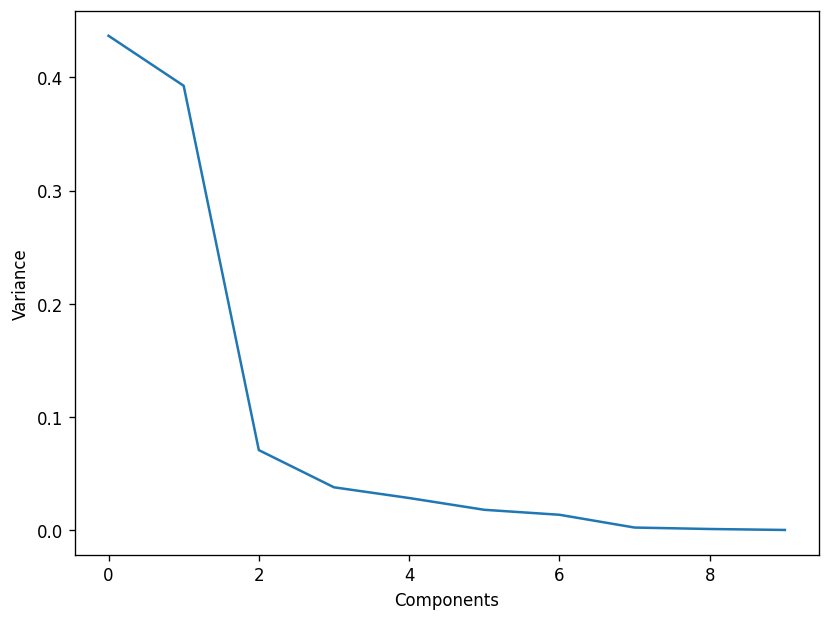

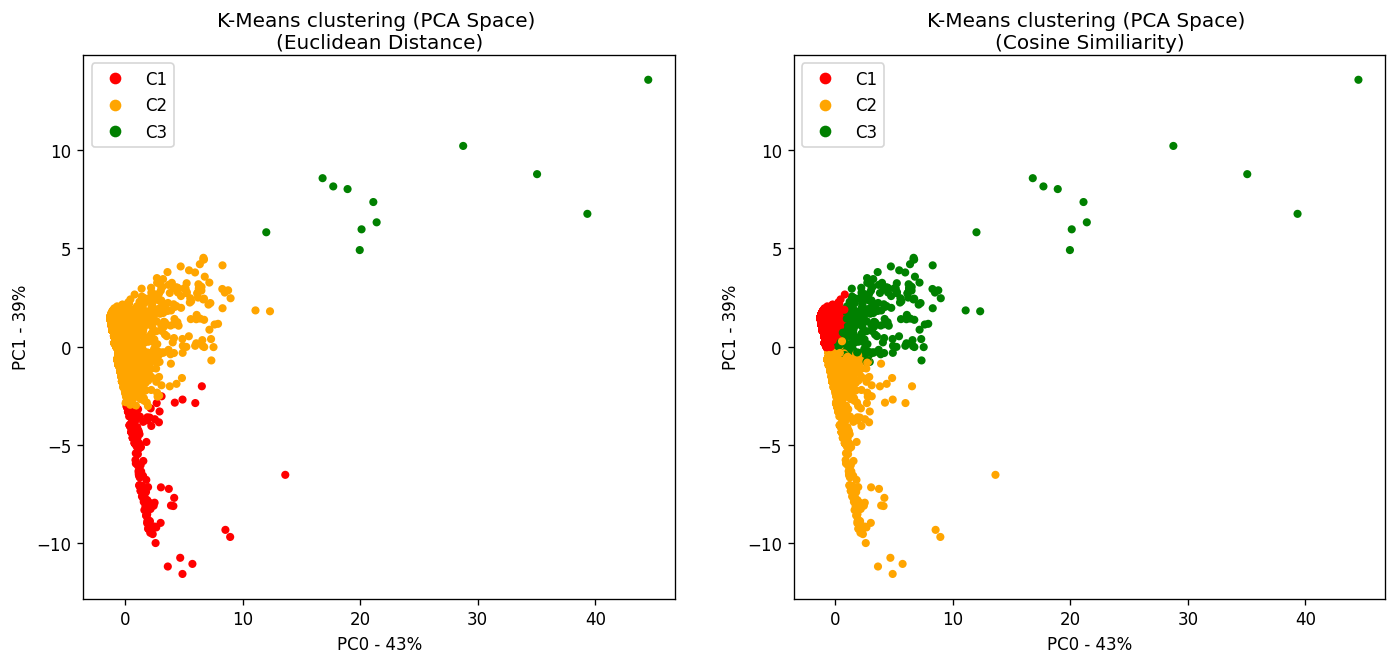

Standardized/Normalized books features matrix : 


,Nb rating,Average Rating,Bayes Rating,Median,STD,Depreciation,Neutral,Appreciations,MaxStarVotes,Class
1484070291,0.374753,0.202109,0.317948,0.127762,0.684345,-0.032396,0.108827,0.458153,0.092210,0.040876
B006PW0OU8,-0.088467,-0.606250,-0.627014,-0.328637,-0.101184,0.051518,-0.089014,-0.103849,-0.292764,0.078582
0142421014,-0.249108,0.253906,0.255033,0.599486,-0.258832,-0.290887,-0.095944,-0.253469,0.432670,0.191799
0743298853,0.496380,-0.014794,-0.021883,0.108056,0.474447,0.423180,0.245110,0.519322,0.077988,0.034571
0452287146,0.177113,-0.314115,-0.475028,-0.412827,0.039852,0.439812,0.504735,0.069960,-0.133860,0.035930
...,...,...,...,...,...,...,...,...,...,...
B00KYRTNZ2,-0.175230,0.621372,0.517048,0.351471,-0.144792,-0.170543,-0.198503,-0.160858,0.253668,0.112449
1496021819,0.381426,0.188715,0.285520,0.353518,0.531285,0.237943,0.014962,0.442048,0.255146,0.113104
0375833234,-0.184326,0.568701,0.505494,0.391443,-0.161259,-0.189939,-0.221079,-0.165507,0.282518,0.125238
B001GQ2BBS,-0.236973,-0.322057,-0.214607,-0.572420,-0.250285,-0.207588,-0.155045,-0.240538,-0.509936,0.136875


PC axis composition : 


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Nb rating,0.053235,0.482209,-0.059354,-0.022675,-0.055732,-0.059959,-0.012773,-0.145859,-0.362281,-7.753815e-01
Average Rating,-0.506382,0.121573,0.446309,0.130774,0.058339,0.292772,0.363321,-0.519908,0.145186,2.220446e-16
Bayes Rating,-0.501255,0.149458,0.437705,0.057505,0.024009,-0.142654,-0.161964,0.668499,-0.193553,-6.938894e-17
Median,-0.566292,-0.048457,-0.485949,-0.650652,-0.099049,0.077510,-0.025427,-0.029256,-0.012287,8.326673e-17
STD,-0.001630,0.520630,-0.003888,-0.073274,-0.046592,-0.323058,-0.180906,0.001450,0.764389,-3.330669e-16
Depreciation,0.116611,0.254029,-0.188778,-0.062897,0.179723,-0.061587,0.846980,0.346704,0.004959,9.263204e-02
Neutral,0.125731,0.362052,-0.112465,0.057279,-0.090655,0.849662,-0.177490,0.243787,0.069694,1.060402e-01
Appreciations,0.027847,0.506781,-0.026981,-0.028963,-0.081626,-0.212614,-0.112964,-0.277883,-0.469068,6.155959e-01
MaxStarVotes,-0.362793,0.027975,-0.559178,0.686761,0.266306,-0.065684,-0.088089,-0.013028,0.010809,-4.510281e-17
Class,-0.083652,-0.061079,-0.088573,0.265791,-0.928888,-0.068750,0.197054,0.060397,0.027298,-4.163336e-17


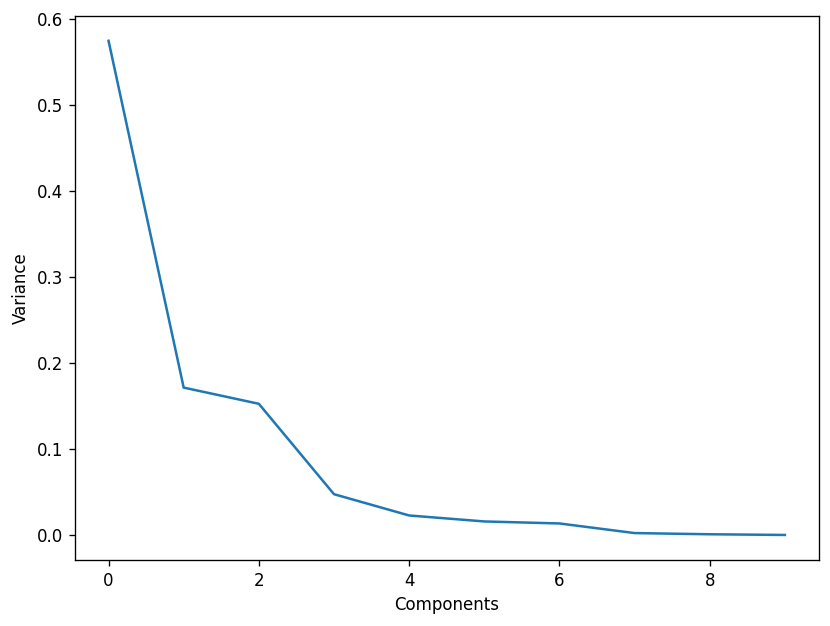

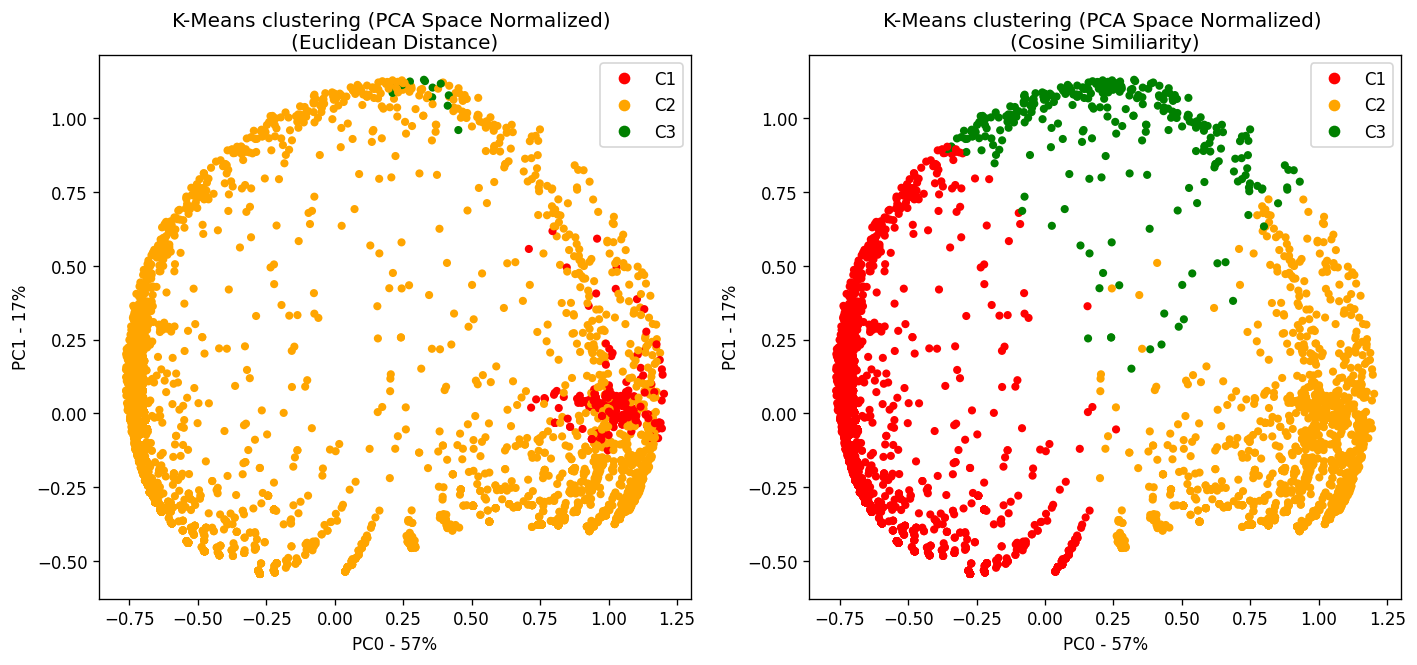

In [25]:
def scatterPlotHelper(plotData):
    fig, ax = plt.subplots(1, len(plotData), figsize=(14,6), dpi=120)
    for i in range(len(plotData)):
        if (plotData[i].axisLabels != []): ax[i].set(xlabel=plotData[i].axisLabels[0], ylabel=plotData[i].axisLabels[1])
        scatter = ax[i].scatter(x=plotData[i].dataXY[0], y=plotData[i].dataXY[1], c=plotData[i].dataLabels, cmap=colors, s=15)
        ax[i].legend(handles=scatter.legend_elements(num=3)[0], labels=CLASSES)
        ax[i].set_title(plotData[i].title, loc='center', wrap=True)
    plt.show()


def calculatePCA(booksData, normalize=False):
    # Data Standardization
    pdBooksFeaturesStandardized = (booksData - booksData.mean()) / booksData.std()
    if (normalize):
        pdBooksFeaturesNormalized = pd.DataFrame(
            data=preprocessing.normalize(pdBooksFeaturesStandardized), 
            columns=booksData.columns, 
            index=booksData.index
        )
    else:
        pdBooksFeaturesNormalized = pdBooksFeaturesStandardized
    # PCA Calculations
    pca = PCA(n_components=booksData.shape[1])
    pca.fit(pdBooksFeaturesNormalized)
    # PCA Results
    booksFeaturesPCA = pd.DataFrame(
        data=pca.components_.T,
        columns=[f"PC{i}" for i in range(len(booksData.columns))],
        index=booksData.columns
    )
    return pdBooksFeaturesNormalized, booksFeaturesPCA, pca

def displayPCAResults(pdBooksFeaturesStandNorm, booksFeaturesPCA, pca):
    # Display standardized data 
    print("Standardized/Normalized books features matrix : ")
    display(pdBooksFeaturesStandNorm)
    # Plot all PCA axis and their contributions
    print("PC axis composition : ")
    display(booksFeaturesPCA)
    # Plot PCA (2 major axis)
    plt.figure(figsize=(8, 6), dpi=120)
    plt.plot(pca.explained_variance_ratio_)
    plt.ylabel("Variance")
    plt.xlabel("Components")
    plt.show()

def displayKmeansClustering(booksData, normalizePca=False, displayPcaResults=False):
    kmeansEucliCoords, kmeansEucliLabels = kmeansClustering(booksData, "euclidean")
    kmeansCosCoords, kmeansCosLabels = kmeansClustering(booksData, "cosine")
    pdBooksFeaturesStandNorm, booksFeaturesPCA, pca = calculatePCA(booksData, normalizePca)
    if (displayPcaResults): displayPCAResults(pdBooksFeaturesStandNorm, booksFeaturesPCA, pca)
    pcaSpace = pca.transform(pdBooksFeaturesStandNorm)
    pcaSpaceXY = (pcaSpace[:,0], pcaSpace[:,1])
    pcaAxisLabels = [f"PC0 - {math.floor(pca.explained_variance_ratio_[0]*100)}%", f"PC1 - {math.floor(pca.explained_variance_ratio_[1]*100)}%"]
    kmeansEucli = PlotData(
        inputData=kmeansEucliCoords,
        dataXY=pcaSpaceXY,
        dataLabels=kmeansEucliLabels, 
        title=f"K-Means clustering (PCA Space{' Normalized' if normalizePca else ''}) \n(Euclidean Distance)",
        axisLabels=pcaAxisLabels
    )
    kmeansCos = PlotData(
        inputData=kmeansCosCoords,
        dataXY=pcaSpaceXY,
        dataLabels=kmeansCosLabels, 
        title=f"K-Means clustering (PCA Space{' Normalized' if normalizePca else ''}) \n(Cosine Similiarity)",
        axisLabels=pcaAxisLabels
    )
    scatterPlotHelper([kmeansEucli, kmeansCos])
    return kmeansEucli, kmeansCos

kmeansEucli, kmeansCos = displayKmeansClustering(pdBooksFeatures, normalizePca=False, displayPcaResults=True)
kmeansEucliNorm, kmeansCosNorm = displayKmeansClustering(pdBooksFeatures, normalizePca=True, displayPcaResults=True)

**Q3 : Interprétation des résultats visuelles**
TODO

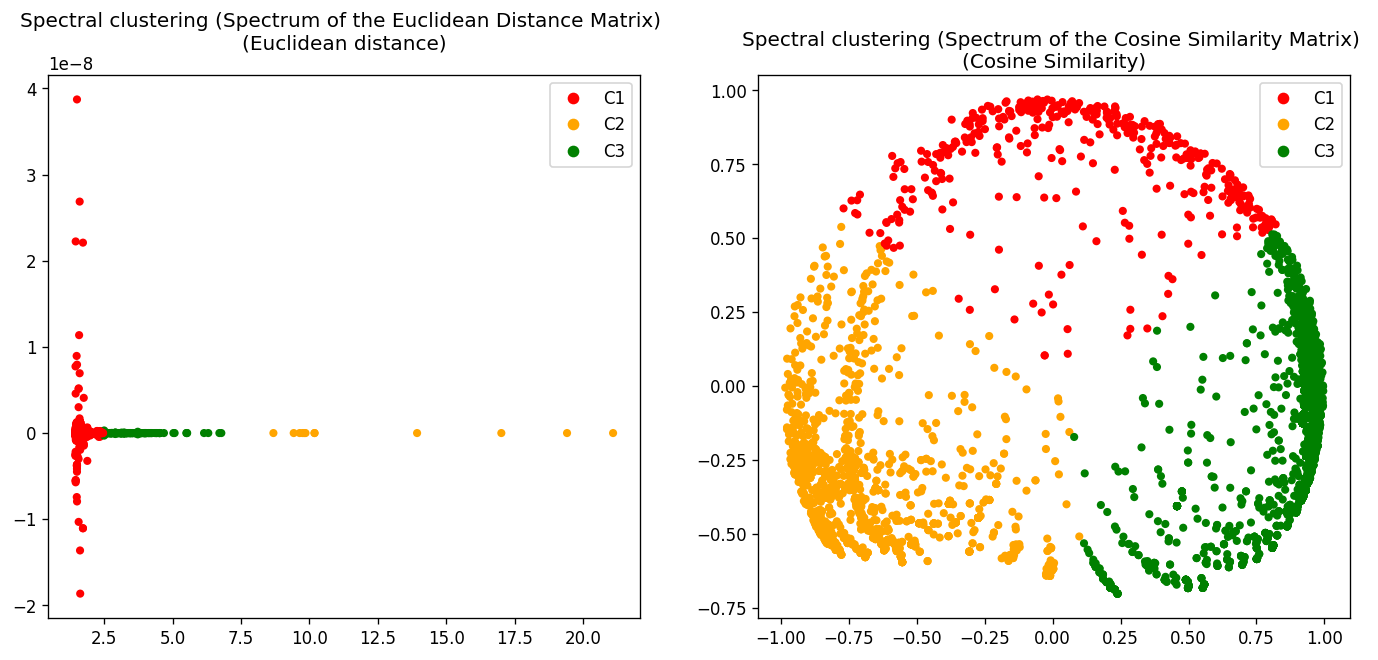

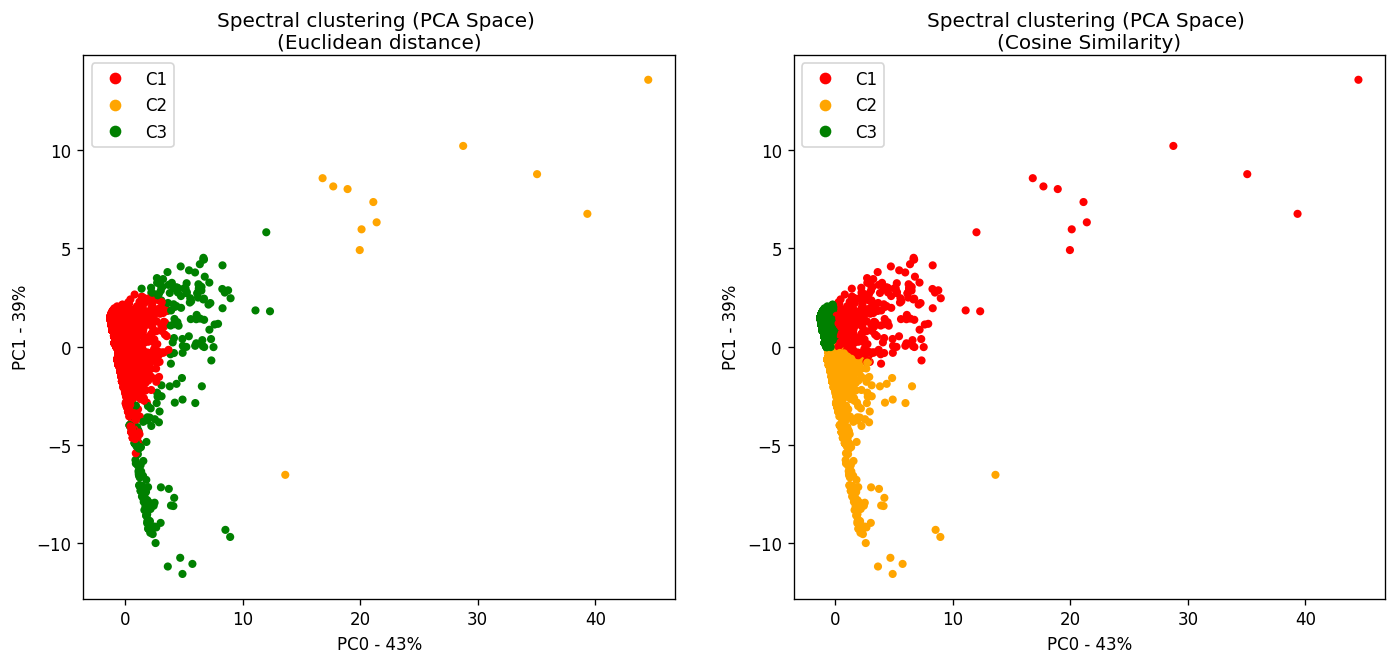

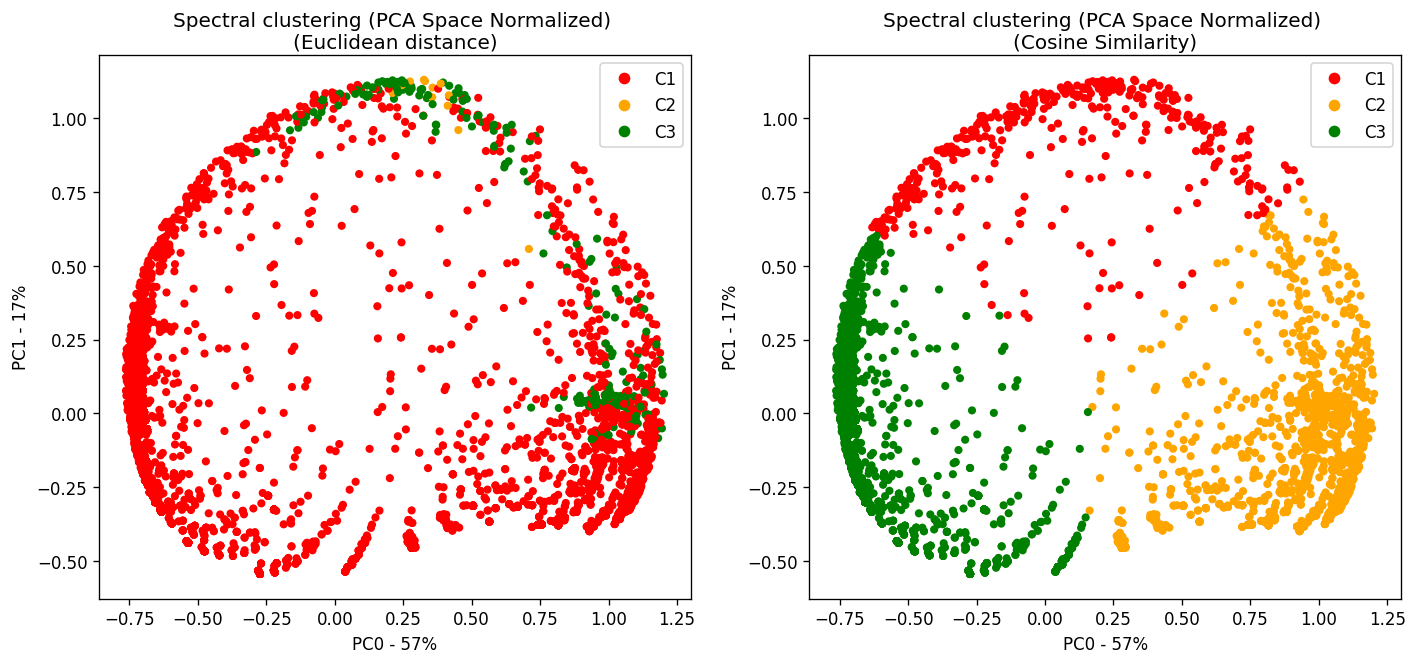

In [26]:
# Q4
def spectralClustering(booksData, distFunc):
    # Standardize data before doing kmeans :
    data = (booksData - booksData.mean()) / booksData.std()
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
    M = sp.spatial.distance.squareform(sp.spatial.distance.pdist(np.asarray(data), distFunc))
    if (distFunc == "cosine"): M = 1 - M # SciPy uses distance cos which is equal to 1 - sim cos
    eigenValues, eigenVectors = np.linalg.eig(M)
    idx =  eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx].real
    eigenVectors = eigenVectors[:,idx].real
    positiveCount = eigenValues[eigenValues > 0].size
    P = np.stack(eigenVectors[:,0:positiveCount])
    D = np.diag(eigenValues[0:positiveCount])
    spectralDataMat = P @ np.sqrt(D)
    kmeans = KMeans(n_clusters=NB_CLUSTERS, random_state=0, max_iter=1000).fit(spectralDataMat[:,0:2])
    return spectralDataMat[:,0:2], kmeans.labels_

def displaySpectralClustering(booksData, kmeansEucli, kmeansCos, kmeansEucliNorm, kmeansCosNorm):
    eucliCoords, spectralEucliLabels = spectralClustering(booksData, "euclidean")
    cosCoords, spectralCosLabels =  spectralClustering(booksData, "cosine")
    spectralEucli = PlotData(
        inputData=eucliCoords,
        dataXY=(eucliCoords[:,0],eucliCoords[:,1]), 
        dataLabels=spectralEucliLabels, 
        title="Spectral clustering (Spectrum of the Euclidean Distance Matrix) \n(Euclidean distance)"
    )
    spectralCos = PlotData(
        inputData=cosCoords,
        dataXY=(cosCoords[:,0],cosCoords[:,1]), 
        dataLabels=spectralCosLabels, 
        title="Spectral clustering (Spectrum of the Cosine Similarity Matrix) \n(Cosine Similarity)"
    )
    scatterPlotHelper([spectralEucli, spectralCos])
    spectralEucliPCASpace = PlotData(
        inputData=eucliCoords,
        dataXY=kmeansEucli.dataXY, 
        dataLabels=spectralEucliLabels, 
        title="Spectral clustering (PCA Space) \n(Euclidean distance)",
        axisLabels=kmeansEucli.axisLabels
    )
    spectralCosPCASpace = PlotData(
        inputData=cosCoords,
        dataXY=kmeansCos.dataXY, 
        dataLabels=spectralCosLabels, 
        title="Spectral clustering (PCA Space) \n(Cosine Similarity)",
        axisLabels=kmeansCos.axisLabels
    )
    scatterPlotHelper([spectralEucliPCASpace, spectralCosPCASpace])
    spectralEucliPCASpaceNorm = PlotData(
        inputData=eucliCoords,
        dataXY=kmeansEucliNorm.dataXY, 
        dataLabels=spectralEucliLabels, 
        title="Spectral clustering (PCA Space Normalized) \n(Euclidean distance)",
        axisLabels=kmeansEucliNorm.axisLabels
    )
    spectralCosPCASpaceNorm = PlotData(
        inputData=cosCoords,
        dataXY=kmeansCosNorm.dataXY, 
        dataLabels=spectralCosLabels, 
        title="Spectral clustering (PCA Space Normalized) \n(Cosine Similarity)",
        axisLabels=kmeansCosNorm.axisLabels
    )
    scatterPlotHelper([spectralEucliPCASpaceNorm, spectralCosPCASpaceNorm])
    return spectralEucli, spectralCos, spectralEucliPCASpace, spectralCosPCASpace, spectralEucliPCASpaceNorm, spectralCosPCASpaceNorm

spectralEucli, spectralCos, spectralEucliPCASpace, spectralCosPCASpace, spectralEucliPCASpaceNorm, spectralCosPCASpaceNorm = displaySpectralClustering(
    pdBooksFeatures[CRITERIAS], 
    kmeansEucli,
    kmeansCos,
    kmeansEucliNorm,
    kmeansCosNorm
)

In [27]:
# Q5
def getAccuracyMatrix(pdBooksFeatures, kmeansEucli, kmeansCos, spectralEucli, spectralCos):
    bookClasses = pdBooksFeatures[["Class"]].to_numpy(dtype=int).T[0]
    perfMetric = np.array([
        [
            sk.metrics.silhouette_score(kmeansEucli.inputData, kmeansEucli.dataLabels, metric='euclidean'), 
            sk.metrics.adjusted_mutual_info_score(kmeansEucli.dataLabels, bookClasses), 
            sk.metrics.silhouette_score(kmeansCos.inputData, kmeansCos.dataLabels, metric="cosine"), 
            sk.metrics.adjusted_mutual_info_score(kmeansCos.dataLabels, bookClasses), 
        ],
        [
            sk.metrics.silhouette_score(spectralEucli.inputData, spectralEucli.dataLabels, metric='euclidean'), 
            sk.metrics.adjusted_mutual_info_score(spectralEucli.dataLabels, bookClasses), 
            sk.metrics.silhouette_score(spectralCos.inputData, spectralCos.dataLabels, metric="cosine"), 
            sk.metrics.adjusted_mutual_info_score(spectralCos.dataLabels, bookClasses), 
        ],
    ])
    return perfMetric

def displayAccuracyMatrix(pdBooksFeatures, kmeansClustering, spectraClustering):
    accMat = getAccuracyMatrix(
        pdBooksFeatures, 
        kmeansClustering[0], 
        kmeansClustering[1], 
        spectraClustering[0], 
        spectraClustering[1]
    )
    display(pd.DataFrame(
        data=accMat, 
        columns=["Silhouet (Euclidean)", "Mut. Info. (Euclidean)", "Silhouet (Cosine)", "Mut. Info. (Cosine)",],
        index=["K-means", "Spectral"]
    ))
    return accMat

_ = displayAccuracyMatrix(
    pdBooksFeatures,
    (kmeansEucli, kmeansCos), 
    (spectralEucli, spectralCos), 
)

,Silhouet (Euclidean),Mut. Info. (Euclidean),Silhouet (Cosine),Mut. Info. (Cosine)
K-means,0.644626,0.648249,0.647373,0.090457
Spectral,0.843192,0.275574,0.829854,0.086124


**b-1) Selon vous quel serait le risque de prendre aléatoirement un sous-ensemble de données pour effectuer les tâches a-1) à a-5) ?**

-> Puisque les 3 catégories ne sont pas distrbué d'une maniere uniforme si on prend aléatoirement un sous ensemble de données, on risque d'avoir des catégories qui seront forcément sous représenter voir même pas présent. Par conséquence, notre clustering sera forcément faux car on risque d'appliquer l'algorithme de clustering sur un ensemble de données qui appartient au même groupe (qui n'as pas de sens).

,1 ⭐,2 ⭐,3 ⭐,4 ⭐,5 ⭐,Depreciation,Neutral,Appreciations,MaxStarVotes,Class
1566251117,3,1,1,0,2,4,1,2,0,0
B007HRACK2,7,4,3,4,2,11,3,6,0,0
B005HIL52M,0,2,1,1,1,2,1,2,1,0
0761139591,3,2,0,0,1,5,0,1,0,0
037550477X,9,3,9,4,6,12,9,10,0,0
...,...,...,...,...,...,...,...,...,...,...
0373113595,0,1,1,3,1,1,1,4,3,2
B00876XRZY,0,0,0,2,3,0,0,5,4,2
B009NBYWAQ,1,1,4,6,5,2,4,11,3,2
0545386985,0,1,2,2,10,1,2,12,4,2


,Nb rating,Average Rating,Bayes Rating,Median,STD,Depreciation,Neutral,Appreciations,MaxStarVotes,Class
1566251117,7.0,2.571429,2.984848,2.0,1.019804,4.0,1.0,2.0,0.0,0.0
B007HRACK2,20.0,2.500000,2.723193,2.0,1.673320,11.0,3.0,6.0,0.0,0.0
B005HIL52M,5.0,3.200000,3.345730,3.0,0.632456,2.0,1.0,2.0,1.0,0.0
0761139591,6.0,2.000000,2.733586,2.0,1.166190,5.0,0.0,1.0,0.0,0.0
037550477X,31.0,2.838710,2.940622,3.0,2.481935,12.0,9.0,10.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
0373113595,6.0,3.666667,3.566919,4.0,0.979796,1.0,1.0,4.0,3.0,2.0
B00876XRZY,5.0,4.600000,3.982094,5.0,1.264911,0.0,0.0,5.0,4.0,2.0
B009NBYWAQ,17.0,3.764706,3.687088,4.0,2.059126,2.0,4.0,11.0,3.0,2.0
0545386985,15.0,4.400000,4.133478,5.0,3.577709,1.0,2.0,12.0,4.0,2.0


Different classes count : 


,Count,%
⭐,3500,33
⭐⭐,3500,33
⭐⭐⭐,3500,33


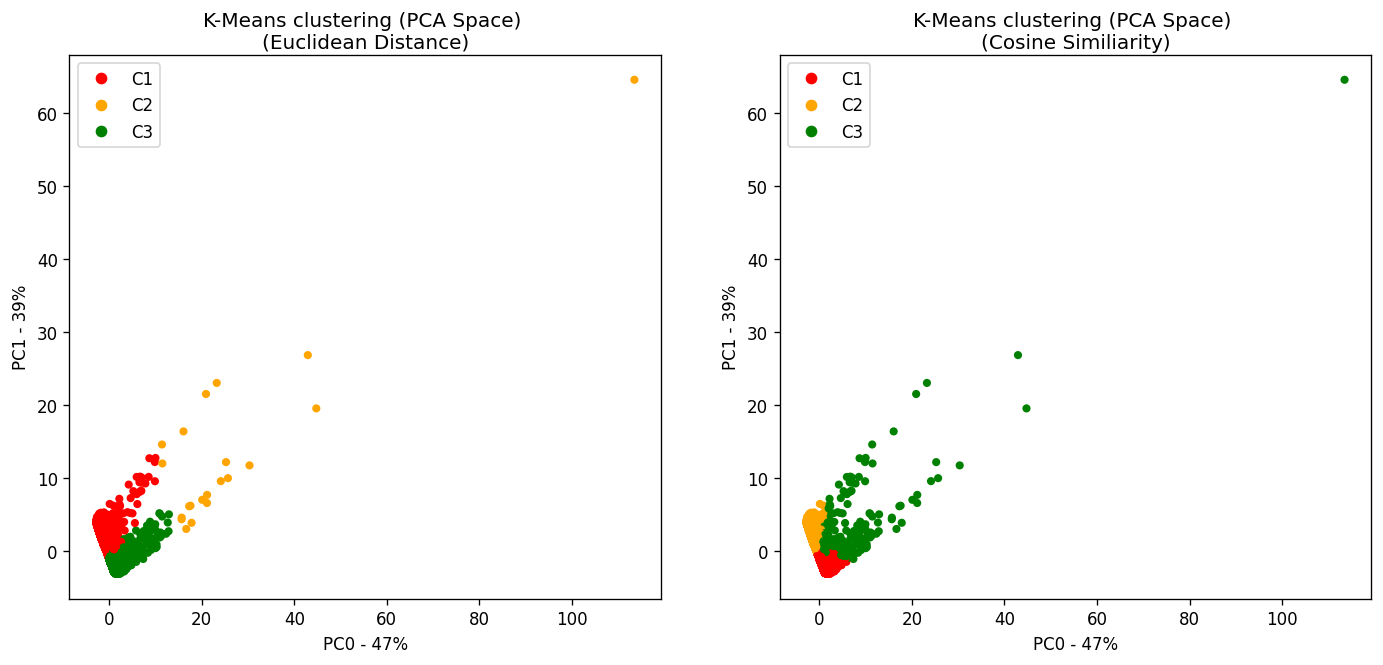

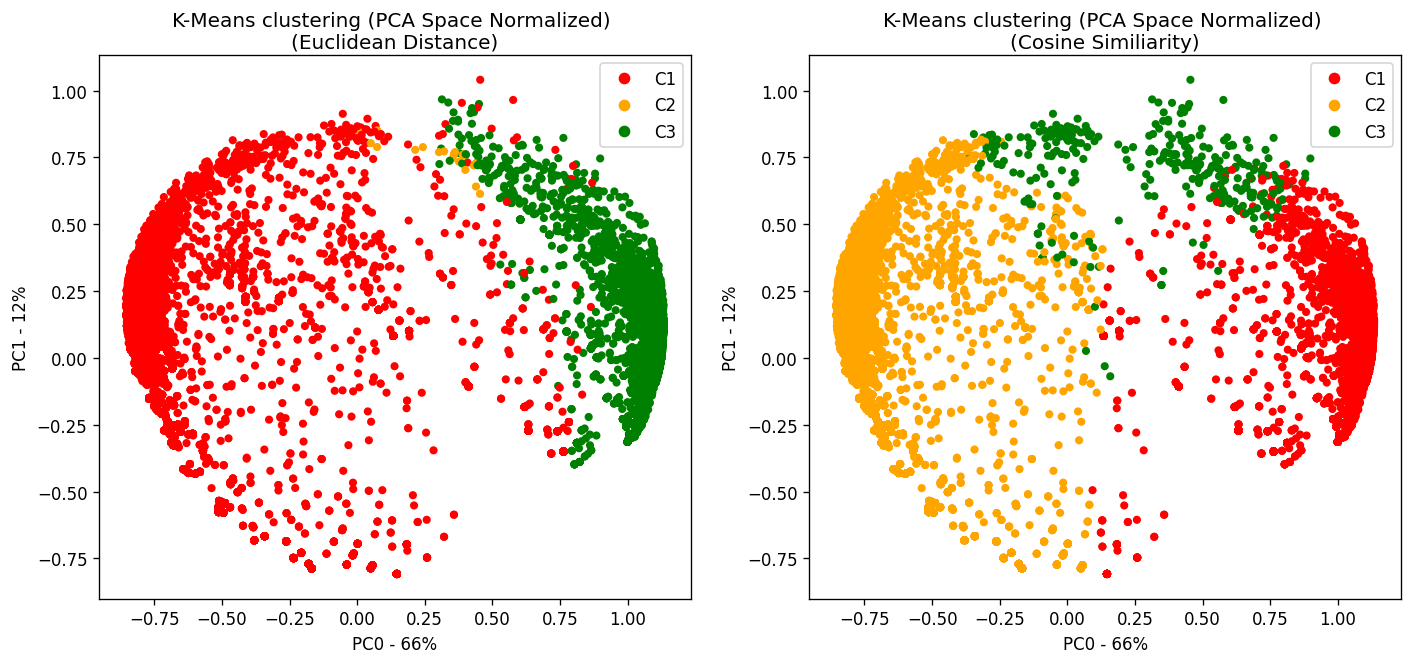

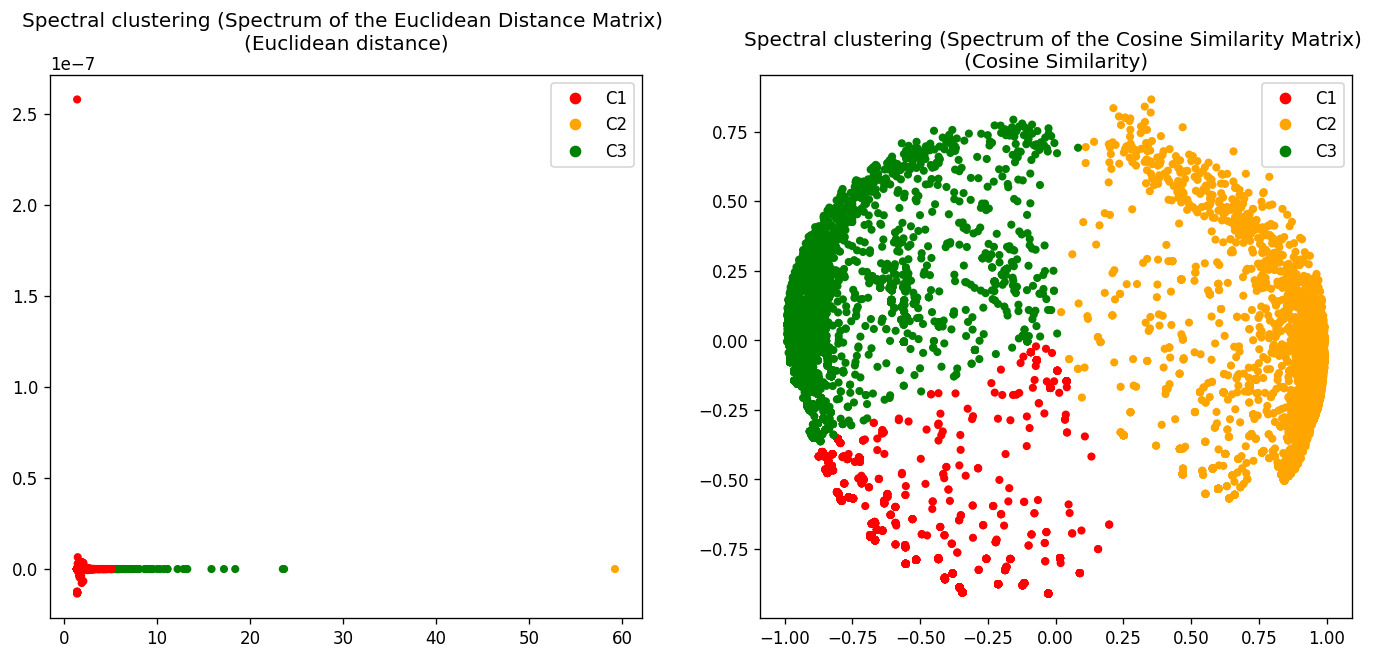

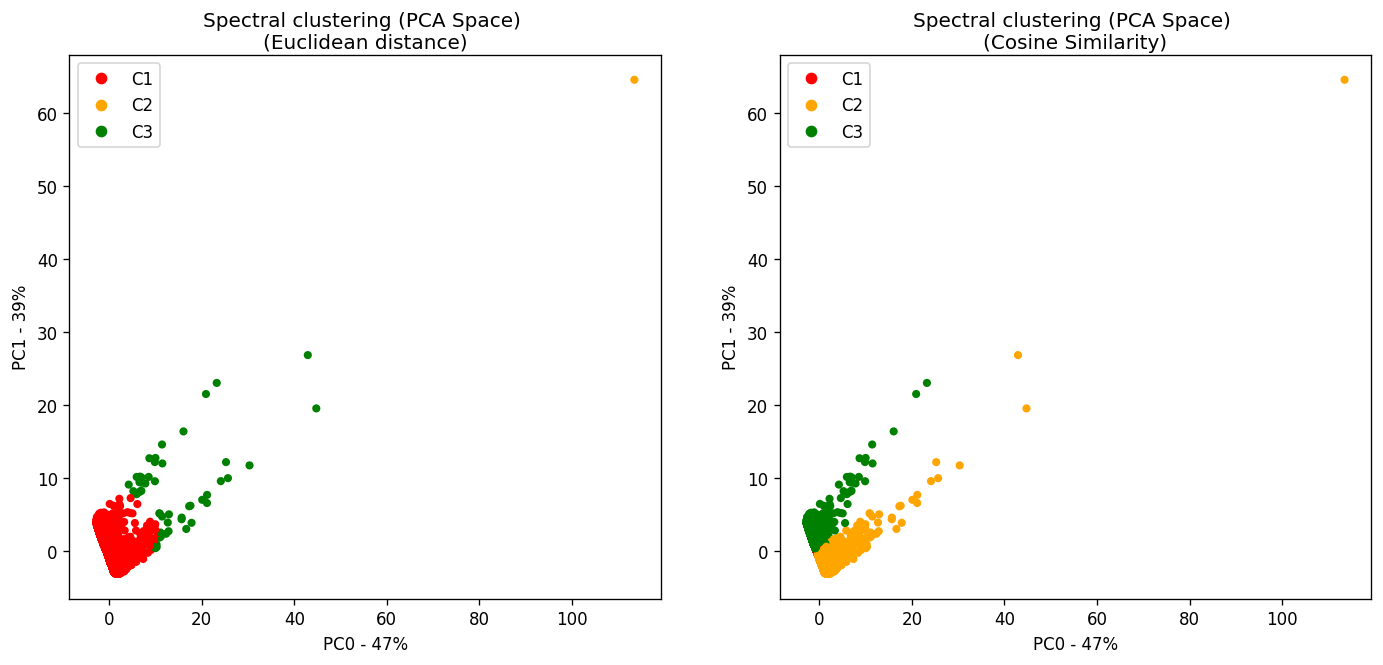

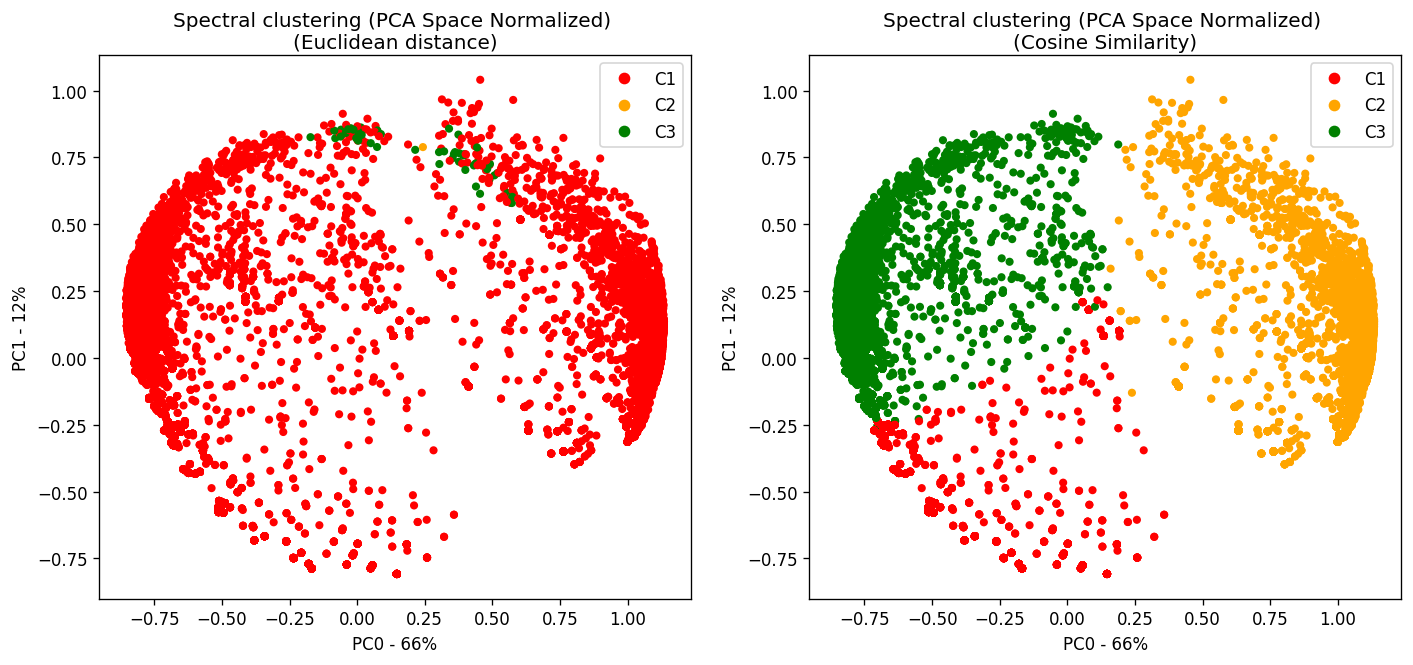

,Silhouet (Euclidean),Mut. Info. (Euclidean),Silhouet (Cosine),Mut. Info. (Cosine)
K-means,0.518051,0.576985,0.656402,0.453325
Spectral,0.950241,0.003408,0.807270,0.558467


In [28]:
# Q B-3
def fullAnalysis(pdBooksFeatures):
    kmeansEucli, kmeansCos = displayKmeansClustering(pdBooksFeatures[CRITERIAS])
    kmeansEucliNorm, kmeansCosNorm = displayKmeansClustering(pdBooksFeatures[CRITERIAS], normalizePca=True)
    spectralEucli, spectralCos, _, _, _, _ = displaySpectralClustering(
        pdBooksFeatures[CRITERIAS], 
        kmeansEucli,
        kmeansCos,
        kmeansEucliNorm,
        kmeansCosNorm
    )
    displayAccuracyMatrix(
        pdBooksFeatures, 
        (kmeansEucli, kmeansCos), 
        (spectralEucli, spectralCos)
    )

#classesCount = [ (pdBooks.Class.values == i).sum() for i in range(0, 3) ]
# nbSamples = np.min(classesCount)
nbSamples = BOOKS_SAMPLING_NB
pdBooksSampled = pdBooks.groupby('Class', group_keys=False).apply(lambda x: x.sample(nbSamples))
display(pdBooksSampled)

pdSampledBooksFeatures = getBookStats(pdBooksSampled)
display(pdSampledBooksFeatures)
displayDifferentClassesCount(pdSampledBooksFeatures)

fullAnalysis(pdSampledBooksFeatures)